ref: https://pbpython.com/monte-carlo.html

# Monte Carlo Analysis (Simulation)
Predict the range of potential value

Monte Carlo analysis (or simulation) involves running many scenarios with different random inputs and summarizing the distribution of the results.

### example: predict sales commission

commission formula:

       commission Amount = Actual Sales * Commission Rate
       
       commission rate:
<img src='https://pbpython.com/images/Excel_Table_4.png'/>

#### Naive approach

One approach might be to assume everyone makes 100% of their target and earns the 4% commission rate. Plugging these values into Excel yields this:

<img src='https://pbpython.com/images/Excel_Table_2.png' width=800 height=600/abs>

Problem: in real world, we never have same commission rate for everyone
solution: run some senario and try a couple of ranges:
<img src='https://pbpython.com/images/Excel_Table_5.png' width=800 height=600/abs>
<img src='https://pbpython.com/images/Excel_Table_6.png' width=800 height=600/abs>

Problem: what is the confidence in this range? what if we need the model for 500 sales or several different rate or actual sales value?


Solution: using Monte Carlo simulation to iterate through th process:
> - determine a range of potential result (commission values)
> - increase the iteration or initial parameter to fit the model for more sales or different rate/sales value

#### Monte Carlo approach
> componments to run a Monte Carlo simulation:
> - the equation to evaluate
> - the random variables for the input

need to decide how many iteration (number of simulations) and how many data for a set (in this example, its how many sales reps)

In [3]:
# import package and plotting style
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

In [4]:
# initial parameters:
num_reps = 500
num_simulations = 1000

equation: address above:
> commission Amount = Actual Sales * Commission Rate

random variables for the equation:
> commission rate (from rate target): 
>> - take a random number between 0%-200% (the intuition about commissions rate)
>> - base on historial data (the distribution of the commission rate)

> actual sales:
>> - base on historical data
>> a random number that within a reasonable range

- for commission rate target distribution:  
Base on historical data:  
<img src='https://pbpython.com/images/monte_carlo_image_hist_pct.png' width=400 height=300/>  
It looks like a normal distribution with a mean of 100 and sd of 10.  
We can use this information to model our input variable for commission rate


In [5]:
# paramater for generate random input for commission rate
avg = 1
std_dev=.1

# the distribution of the commission rate is normal distribution
comm_rate_target = np.random.normal(avg, std_dev, num_reps).round(2)

In [6]:
# first 10 items look like:
comm_rate_target[:10]

array([0.92, 1.08, 1.05, 1.1 , 1.1 , 1.08, 1.1 , 1.1 , 1.14, 0.84])

- for actual sales distribution:
Base on historical data:  
<img src='https://pbpython.com/images/monte_carlo_sales_target.png' width=400 heigh=300/>
It is not a normal distribution. There are 6 buckets and the frequency gets lower as the amount increases


This distribution could be indicative of a very simple target setting process where individuals are bucketed into certain groups and given targets consistently based on their tenure, territory size or sales pipeline.

In [7]:
'''
Use a uniform distribution with a lower probability rates for some of the values
build this using numpy.random.choice 
(https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html)
'''

sales_values = [75000, 100000, 200000, 300000, 400000, 500000]
sales_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_values, num_reps, p=sales_prob)

In [8]:
sales_target[:10]

array([200000, 100000,  75000, 100000,  75000, 200000, 100000,  75000,
       400000, 100000])

Above is our two input distributions, let's integrate this into a dataframe and generate a sale values:  
for the sales value, we use performance distribution (comm_rate target) base on the historical data to generate actual sales

In [15]:
df = pd.DataFrame(index=range(num_reps), data={'comm_rate_target': comm_rate_target,
                                              'sales_target': sales_target})
df['sales'] = df['comm_rate_target']*df['sales_target']

In [16]:
df.head()

,comm_rate_target,sales_target,sales
0,0.92,200000,184000.0
1,1.08,100000,108000.0
2,1.05,75000,78750.0
3,1.10,100000,110000.0
4,1.10,75000,82500.0


Check if the distributions of these two variables are the same as how we expected

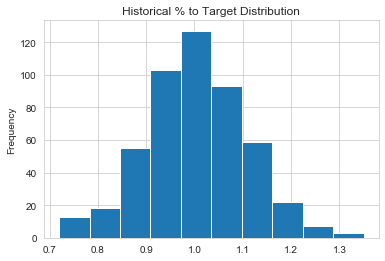

In [34]:
# Simple histogram to confirm distribution looks as expected
df['comm_rate_target'].plot(kind='hist', title='Historical % to Target Distribution')

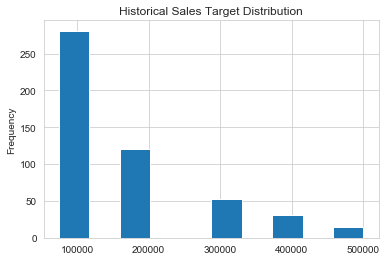

In [35]:
# Look at the sales target distribution
df['sales_target'].plot(kind='hist', title='Historical Sales Target Distribution')

create a way to map comm_rate target to comm_rate

In [14]:
def calc_commission_rate(x):
    """ Return the commission rate based on the table:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

Adding commission rate and commission amount into df

In [17]:
df['comm_rate'] = df['comm_rate_target'].apply(calc_commission_rate)
df['comm_amount'] = df['comm_rate'] * df['sales']

In [18]:
df.head()

,comm_rate_target,sales_target,sales,comm_rate,comm_amount
0,0.92,200000,184000.0,0.03,5520.0
1,1.08,100000,108000.0,0.04,4320.0
2,1.05,75000,78750.0,0.04,3150.0
3,1.10,100000,110000.0,0.04,4400.0
4,1.10,75000,82500.0,0.04,3300.0


df is the model that we would have done in Excel in Navie approach.

Next step is to loop, stimulated models and its result.
from the distribution of those stiumlation and the result, we can establish the confidence of the result should be

In [23]:
def MC_approach_commission_amount(num_reps=num_reps, num_simulations=num_simulations):
    
    # paramater for random input for comm_rate_tartet
    avg = 1
    std_dev=.1
    
    # paramater for random input for sales
    sales_values = [75000, 100000, 200000, 300000, 400000, 500000]
    sales_prob = [.3, .3, .2, .1, .05, .05]


    # a list to keep all the results for each simulation
    all_stats = []
    
    # start simulations
    for i in range(num_simulations):
        
        # random inputs for the equation
        sales_target = np.random.choice(sales_values, num_reps, p=sales_prob)
        comm_rate_target = np.random.normal(avg, std_dev, num_reps).round(2)
        
        # df for the modle
        df = pd.DataFrame(index=range(num_reps), data={'comm_rate_target': comm_rate_target,
                                                       'sales_target': sales_target})
        
        # using comm_rate_targe to get the actual sales
        df['sales'] = df['comm_rate_target'] * df['sales_target']
        
        # determine the commission rate and calculate commission amount
        df['comm_rate'] = df['comm_rate_target'].apply(calc_commission_rate)
        df['comm_amount'] = df['comm_rate'] * df['sales']
        
        # track this in all_stats
        all_stats.append([df['sales'].sum().round(0),
                          df['comm_amount'].sum().round(0),
                          df['sales_target'].sum().round(0)])
        
    return all_stats
        

In [24]:
result = MC_approach_commission_amount(num_reps, num_simulations)

In [26]:
results_df = pd.DataFrame.from_records(result, columns=['Sales',
                                                        'Commission_Amount',
                                                       'Sales_Target'])

In [29]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,833,714.5","2,861,944.153","83,835,200.0"
std,"2,742,761.250412864","104,332.00446709397","2,677,973.1141294157"
min,"75,431,000.0","2,534,582.0","76,225,000.0"
25%,"82,049,250.0","2,794,153.25","82,100,000.0"
50%,"83,864,875.0","2,863,602.5","83,850,000.0"
75%,"85,548,750.0","2,926,784.25","85,456,250.0"
max,"92,795,500.0","3,237,222.0","93,250,000.0"


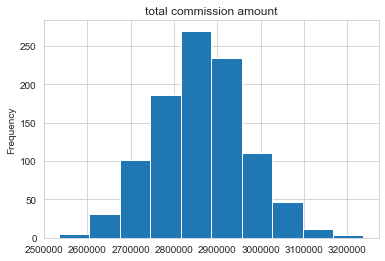

In [32]:
results_df['Commission_Amount'].plot(kind='hist', title='total commission amount')

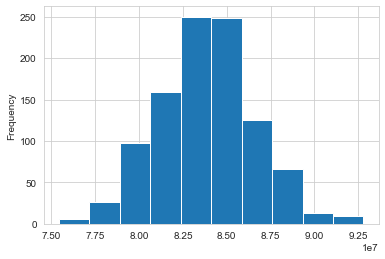

In [33]:
results_df['Sales'].plot(kind='hist')